In [6]:
from google.colab import drive
import os

# Mount Google Drive
if not os.path.exists('/content/drive'):
        print("📂 Mounting Google Drive...")
        drive.mount('/content/drive')
else:
        print("✅ Google Drive already mounted.")

✅ Google Drive already mounted.


In [7]:
### PULL CHANGES ###
repo_path = "/content/drive/MyDrive/Colab_Notebooks/Repositories/MA_LP_Regression_Model"

# Change directory to your repository
# The os.chdir command is the Python equivalent of %cd
os.chdir(repo_path)

# Pull the latest changes from the main branch
!git pull origin main

From https://github.com/CaptainMorgigi/MA_LP_Regression_Model
 * branch            main       -> FETCH_HEAD
Already up to date.


In [8]:
# Replace with your actual GitHub username and email
!git config --global user.name "CaptainMorgigi"
!git config --global user.email "fmorgalla@yahoo.de"

# --- 1. Add a descriptive commit message ---
commit_message = "ADDING GIT PULL & PUSH CELLS"

# --- 2. Add, commit, and push the changes ---
!git add .
!git commit -m "{commit_message}"
!git push

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@171964cdc495.(none)')
Everything up-to-date


In [3]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 90.5 MB/s eta 0:00:00


In [ ]:
import os
import tarfile
import glob
import re
from pathlib import Path
import json
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import rasterio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================

# --- Model & Training Hyperparameters ---
BATCH_SIZE = 16
LEARNING_RATE = 0.005
NUM_EPOCHS = 200
VALIDATION_SPLIT = 0.2 # 20% of training data for validation
RANDOM_SEED = 42 # for reproducible splits
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# VARIABLE DEFINITION
DRIVE_DATA_BASE_PATH = "/content/drive/MyDrive/Colab_Notebooks/Datasets/BioMassters/Data_ready_for_training"
MODEL_SAVE_BASE_PATH = "/content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results"
ORBIT = 'desc'
MODEL_DESCRIPTION = "LP_1_Layer_v1"
VERSION = f"{MODEL_DESCRIPTION}_BS{BATCH_SIZE}_LR{str(LEARNING_RATE).split('.')[1]}_EP{NUM_EPOCHS}_SEED{RANDOM_SEED}_ValSpl{int(float(str(VALIDATION_SPLIT).split('.')[1])*10)}" # for name of saved & trained model
print(f"Model Version: {VERSION}")

# --- Set paths to your data on Google Drive --L-
# NOTE: Please update these paths to match your file locations on Google Drive.

TRAIN_FEATURES_TAR = os.path.join(DRIVE_DATA_BASE_PATH, f"ENCODED_TRAIN_FEATURES_s1_{ORBIT}_July_PatchSize_80_OutputType_patch.tar.gz")
TRAIN_LABELS_TAR = os.path.join(DRIVE_DATA_BASE_PATH, "train_agbm.tar.gz")
TEST_FEATURES_TAR = os.path.join(DRIVE_DATA_BASE_PATH, f"ENCODED_TEST_FEATURES_s1_{ORBIT}_July_PatchSize_80_OutputType_patch.tar.gz")
TEST_LABELS_TAR = os.path.join(DRIVE_DATA_BASE_PATH, "test_agbm.tar.gz")

# --- Local directory for extracted data (for faster I/O) ---
LOCAL_DATA_PATH = "/content/local_biomassters_data"
# This directory will hold the original 8689 training files
FULL_TRAIN_FEATURES_DIR = os.path.join(LOCAL_DATA_PATH, "full_train_features")
FULL_TRAIN_LABELS_DIR = os.path.join(LOCAL_DATA_PATH, "full_train_labels")
# This directory will hold the 2773 test files for final inference
INFERENCE_FEATURES_DIR = os.path.join(LOCAL_DATA_PATH, "inference_features")
INFERENCE_LABELS_DIR = os.path.join(LOCAL_DATA_PATH, "inference_labels")

# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)

Model Version: LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20


In [ ]:
# ==============================================================================
# 2. DATA PREPARATION
# ==============================================================================

def mount_gdrive():
    """Mounts Google Drive to the Colab environment."""
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        print("📂 Mounting Google Drive...")
        drive.mount('/content/drive')
    else:
        print("✅ Google Drive already mounted.")

def extract_tar_archive(tar_path, dest_dir):
    """Extracts a .tar.gz file to a destination directory."""
    print(f"  -> Extracting {os.path.basename(tar_path)} to {dest_dir}...")
    # The mode is changed from 'r' to 'r:gz' to handle gzip compression
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=dest_dir)
    print(f"  -> Extraction complete.")

def prepare_data():
    """
    Ensures data is copied from Google Drive and extracted to the local
    Colab file system for faster access during training.
    """
    print("\n🚀 Starting data preparation...")
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    data_archives = {
        TRAIN_FEATURES_TAR: FULL_TRAIN_FEATURES_DIR,
        TRAIN_LABELS_TAR: FULL_TRAIN_LABELS_DIR,
        TEST_FEATURES_TAR: INFERENCE_FEATURES_DIR,
        TEST_LABELS_TAR: INFERENCE_LABELS_DIR,
    }

    all_extracted = all(os.path.exists(dest) and os.listdir(dest) for dest in data_archives.values())

    if all_extracted:
        print("✅ All data is already extracted to local directory. Skipping extraction.")
        return

    print("Copying and extracting data. This may take a few minutes...")
    for tar_path, dest_dir in data_archives.items():
        if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
            os.makedirs(dest_dir, exist_ok=True)
            if os.path.exists(tar_path):
                extract_tar_archive(tar_path, dest_dir)
            else:
                print(f"⚠️ WARNING: Archive not found at {tar_path}. Please check the path.")
        else:
            print(f"✅ Data in {dest_dir} already exists.")

    print("Data preparation finished!\n")

In [ ]:
# ==============================================================================
# 3. PYTORCH DATASET & DATALOADER
# ==============================================================================

def get_id_from_filename(filename):
    """Extracts the 8-character ID from a feature or label filename."""
    # This looks for 8 letters (a-z, A-Z) or digits (0-9).
    match = re.search(r'([a-zA-Z0-9]{8})_S1', os.path.basename(filename))
    if match:
        return match.group(1)

    # FIX: Fallback for label files with the format {ID}_agbm.tif
    match = re.search(r'^([a-zA-Z0-9]{8})_agbm\.tif$', os.path.basename(filename))
    if match:
        return match.group(1)

    return None

class BiomassDataset(Dataset):
    """Custom PyTorch Dataset for loading biomass features and labels."""
    def __init__(self, features_dir, labels_dir):
        self.features_dir = features_dir
        self.labels_dir = labels_dir

        # Create a map of all available labels
        self.label_map = {
            get_id_from_filename(f): f for f in glob.glob(os.path.join(labels_dir, "*.tif"))
        }
        # Filter out any label files that didn't have a valid ID
        self.label_map = {k: v for k, v in self.label_map.items() if k is not None}

        # Pre-filter feature files to ensure they have a matching label
        all_feature_files = glob.glob(os.path.join(features_dir, "**/*.pt"), recursive=True)
        self.feature_files = []

        print(f"Found {len(all_feature_files)} total feature files. Filtering for matches...")

        for f_path in all_feature_files:
            file_id = get_id_from_filename(f_path)
            if file_id and file_id in self.label_map:
                self.feature_files.append(f_path)

        print(f"Found {len(self.feature_files)} valid, matched feature-label pairs.")

        if not self.feature_files:
            raise RuntimeError(f"No valid, matching feature/label pairs were found in {features_dir}. Please check file names and directories.")


    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        feature_path = self.feature_files[idx]
        feature_tensor = torch.load(feature_path)

        file_id = get_id_from_filename(feature_path)
        # This check is now redundant due to pre-filtering, but good for safety
        if not file_id or file_id not in self.label_map:
            raise FileNotFoundError(f"Could not find matching label for feature ID: {file_id}")

        label_path = self.label_map[file_id]
        with rasterio.open(label_path) as src:
            label_array = src.read(1).astype(np.float32)
            if src.nodata is not None:
                label_array[label_array == src.nodata] = 0.0
        label_tensor = torch.from_numpy(label_array).unsqueeze(0)
        return feature_tensor, label_tensor

In [ ]:
# ==============================================================================
# 4. MODEL ARCHITECTURE
# ==============================================================================

class LinearProbingModel(nn.Module):
    """A simple linear probing model for biomass regression."""
    def __init__(self, in_features=768, out_channels=1):
        super(LinearProbingModel, self).__init__()
        self.probe = nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=out_channels, kernel_size=1),
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        return self.probe(x)

In [ ]:
# ==============================================================================
# 5. TRAINING AND EVALUATION LOOPS
# ==============================================================================

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Runs a single training epoch."""
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(mse_loss=loss.item())
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device, desc="Evaluating"):
    """
    Runs evaluation on a given dataset and calculates MSE, RMSE, MAE, and R-squared.
    """
    model.eval()
    all_preds, all_labels = [], []
    progress_bar = tqdm(dataloader, desc=desc, leave=False)

    with torch.no_grad():
        for features, labels in progress_bar:
            features = features.to(device)
            outputs = model(features)
            all_preds.append(outputs.view(-1).cpu())
            all_labels.append(labels.view(-1).cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    mse = torch.mean((all_preds - all_labels) ** 2)
    ss_total = torch.sum((all_labels - torch.mean(all_labels)) ** 2)
    ss_res = torch.sum((all_labels - all_preds) ** 2)

    # Add a small epsilon to ss_total to prevent division by zero if all labels are the same
    r2 = (1 - (ss_res / (ss_total + 1e-8))).item()

    return {
        "mse": mse.item(),
        "rmse": torch.sqrt(mse).item(),
        "mae": torch.mean(torch.abs(all_preds - all_labels)).item(),
        "r2": r2
    }

In [ ]:
# ==============================================================================
# 6. VISUALIZATION
# ==============================================================================

def plot_curves(train_loss_history, val_metrics_history, save_path=None):
    """Plots the training and validation metric curves and optionally saves the plot."""
    epochs = range(1, len(train_loss_history) + 1)


    # Extract validation metrics
    val_mse = [m['mse'] for m in val_metrics_history]
    val_rmse = [m['rmse'] for m in val_metrics_history]
    val_mae = [m['mae'] for m in val_metrics_history]
    val_r2 = [m['r2'] for m in val_metrics_history]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)

    # Plot 1: MSE Loss
    axs[0, 0].plot(epochs, train_loss_history, 'bo-', label='Training MSE')
    axs[0, 0].plot(epochs, val_mse, 'ro-', label='Validation MSE')
    axs[0, 0].set_title('Training vs. Validation MSE Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot 2: RMSE
    axs[0, 1].plot(epochs, val_rmse, 'go-', label='Validation RMSE')
    axs[0, 1].set_title('Validation RMSE')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('RMSE (tons)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot 3: MAE
    axs[1, 0].plot(epochs, val_mae, 'mo-', label='Validation MAE')
    axs[1, 0].set_title('Validation MAE')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('MAE (tons)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot 4: R-squared
    axs[1, 1].plot(epochs, val_r2, 'yo-', label='Validation R²')
    axs[1, 1].set_title('Validation R-squared')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('R²')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Plot saved to: {save_path}")

    plt.show()

Using device: CUDA
Starting Run Version: LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20
📂 Mounting Google Drive...
Mounted at /content/drive

🚀 Starting data preparation...
Copying and extracting data. This may take a few minutes...
  -> Extracting ENCODED_TRAIN_FEATURES_s1_desc_July_PatchSize_80_OutputType_patch.tar.gz to /content/local_biomassters_data/full_train_features...


/tmp/ipython-input-4075779985.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=dest_dir)


  -> Extraction complete.
  -> Extracting train_agbm.tar.gz to /content/local_biomassters_data/full_train_labels...
  -> Extraction complete.
  -> Extracting ENCODED_TEST_FEATURES_s1_desc_July_PatchSize_80_OutputType_patch.tar.gz to /content/local_biomassters_data/inference_features...
  -> Extraction complete.
  -> Extracting test_agbm.tar.gz to /content/local_biomassters_data/inference_labels...
  -> Extraction complete.
Data preparation finished!

Creating and splitting datasets...
Found 8689 total feature files. Filtering for matches...
Found 8689 valid, matched feature-label pairs.
Found 2773 total feature files. Filtering for matches...
Found 2773 valid, matched feature-label pairs.
✅ Datasets created and split successfully.
  - Training samples:   6952
  - Validation samples: 1737
  - Inference samples:  2773

Initializing model...
✅ Model initialized.

🔥 Starting training for 200 epochs...

--- Epoch 1/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 1 Summary:
  -> Avg. Training MSE Loss: 5467.2186
  -> Validation Metrics:
     - MSE:  5087.7871
     - RMSE: 71.3287 (tons)
     - MAE:  54.5256 (tons)
     - R²:   0.0289
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 2/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 2 Summary:
  -> Avg. Training MSE Loss: 4983.7709
  -> Validation Metrics:
     - MSE:  5052.2178
     - RMSE: 71.0790 (tons)
     - MAE:  54.1693 (tons)
     - R²:   0.0357
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 3/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 3 Summary:
  -> Avg. Training MSE Loss: 4963.4741
  -> Validation Metrics:
     - MSE:  5034.6748
     - RMSE: 70.9554 (tons)
     - MAE:  53.6982 (tons)
     - R²:   0.0390
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 4/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 4 Summary:
  -> Avg. Training MSE Loss: 4948.4699
  -> Validation Metrics:
     - MSE:  5020.3608
     - RMSE: 70.8545 (tons)
     - MAE:  53.5999 (tons)
     - R²:   0.0417
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 5/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 5 Summary:
  -> Avg. Training MSE Loss: 4933.5388
  -> Validation Metrics:
     - MSE:  5008.0254
     - RMSE: 70.7674 (tons)
     - MAE:  53.2688 (tons)
     - R²:   0.0441
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 6/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 6 Summary:
  -> Avg. Training MSE Loss: 4919.6951
  -> Validation Metrics:
     - MSE:  5000.2500
     - RMSE: 70.7124 (tons)
     - MAE:  53.8329 (tons)
     - R²:   0.0456
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 7/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 7 Summary:
  -> Avg. Training MSE Loss: 4909.5611
  -> Validation Metrics:
     - MSE:  4985.1958
     - RMSE: 70.6059 (tons)
     - MAE:  53.5572 (tons)
     - R²:   0.0485
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 8/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 8 Summary:
  -> Avg. Training MSE Loss: 4900.4590
  -> Validation Metrics:
     - MSE:  4971.9302
     - RMSE: 70.5119 (tons)
     - MAE:  53.1815 (tons)
     - R²:   0.0510
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 9/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 9 Summary:
  -> Avg. Training MSE Loss: 4889.3449
  -> Validation Metrics:
     - MSE:  4964.3628
     - RMSE: 70.4582 (tons)
     - MAE:  53.3908 (tons)
     - R²:   0.0524
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 10/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 10 Summary:
  -> Avg. Training MSE Loss: 4882.7704
  -> Validation Metrics:
     - MSE:  4955.5635
     - RMSE: 70.3958 (tons)
     - MAE:  53.3310 (tons)
     - R²:   0.0541
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 11/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 11 Summary:
  -> Avg. Training MSE Loss: 4878.0186
  -> Validation Metrics:
     - MSE:  4956.9590
     - RMSE: 70.4057 (tons)
     - MAE:  53.7184 (tons)
     - R²:   0.0538

--- Epoch 12/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 12 Summary:
  -> Avg. Training MSE Loss: 4866.4310
  -> Validation Metrics:
     - MSE:  4939.0430
     - RMSE: 70.2783 (tons)
     - MAE:  52.8965 (tons)
     - R²:   0.0573
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 13/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 13 Summary:
  -> Avg. Training MSE Loss: 4860.1243
  -> Validation Metrics:
     - MSE:  4941.6187
     - RMSE: 70.2966 (tons)
     - MAE:  53.5493 (tons)
     - R²:   0.0568

--- Epoch 14/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 14 Summary:
  -> Avg. Training MSE Loss: 4856.8710
  -> Validation Metrics:
     - MSE:  4926.7559
     - RMSE: 70.1908 (tons)
     - MAE:  52.8260 (tons)
     - R²:   0.0596
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 15/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 15 Summary:
  -> Avg. Training MSE Loss: 4852.0974
  -> Validation Metrics:
     - MSE:  4921.9360
     - RMSE: 70.1565 (tons)
     - MAE:  52.9498 (tons)
     - R²:   0.0605
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 16/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 16 Summary:
  -> Avg. Training MSE Loss: 4845.3124
  -> Validation Metrics:
     - MSE:  4920.1050
     - RMSE: 70.1435 (tons)
     - MAE:  52.4899 (tons)
     - R²:   0.0609
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 17/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 17 Summary:
  -> Avg. Training MSE Loss: 4841.6895
  -> Validation Metrics:
     - MSE:  4913.4438
     - RMSE: 70.0960 (tons)
     - MAE:  52.9407 (tons)
     - R²:   0.0622
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 18/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 18 Summary:
  -> Avg. Training MSE Loss: 4840.3451
  -> Validation Metrics:
     - MSE:  4913.3955
     - RMSE: 70.0956 (tons)
     - MAE:  53.1473 (tons)
     - R²:   0.0622
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 19/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 19 Summary:
  -> Avg. Training MSE Loss: 4834.9399
  -> Validation Metrics:
     - MSE:  4905.8359
     - RMSE: 70.0417 (tons)
     - MAE:  52.8311 (tons)
     - R²:   0.0636
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 20/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 20 Summary:
  -> Avg. Training MSE Loss: 4833.1629
  -> Validation Metrics:
     - MSE:  4909.6294
     - RMSE: 70.0687 (tons)
     - MAE:  53.2248 (tons)
     - R²:   0.0629

--- Epoch 21/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 21 Summary:
  -> Avg. Training MSE Loss: 4827.4469
  -> Validation Metrics:
     - MSE:  4900.1992
     - RMSE: 70.0014 (tons)
     - MAE:  52.8495 (tons)
     - R²:   0.0647
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 22/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 22 Summary:
  -> Avg. Training MSE Loss: 4828.8413
  -> Validation Metrics:
     - MSE:  4897.9829
     - RMSE: 69.9856 (tons)
     - MAE:  52.8749 (tons)
     - R²:   0.0651
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 23/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 23 Summary:
  -> Avg. Training MSE Loss: 4821.8847
  -> Validation Metrics:
     - MSE:  4895.2793
     - RMSE: 69.9663 (tons)
     - MAE:  52.8295 (tons)
     - R²:   0.0656
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 24/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 24 Summary:
  -> Avg. Training MSE Loss: 4822.5853
  -> Validation Metrics:
     - MSE:  4899.3369
     - RMSE: 69.9953 (tons)
     - MAE:  53.1876 (tons)
     - R²:   0.0648

--- Epoch 25/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 25 Summary:
  -> Avg. Training MSE Loss: 4821.6493
  -> Validation Metrics:
     - MSE:  4890.7632
     - RMSE: 69.9340 (tons)
     - MAE:  52.4765 (tons)
     - R²:   0.0665
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 26/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 26 Summary:
  -> Avg. Training MSE Loss: 4817.0869
  -> Validation Metrics:
     - MSE:  4887.0244
     - RMSE: 69.9073 (tons)
     - MAE:  52.5923 (tons)
     - R²:   0.0672
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 27/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 27 Summary:
  -> Avg. Training MSE Loss: 4817.5581
  -> Validation Metrics:
     - MSE:  4885.6279
     - RMSE: 69.8973 (tons)
     - MAE:  52.4429 (tons)
     - R²:   0.0675
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 28/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 28 Summary:
  -> Avg. Training MSE Loss: 4814.8397
  -> Validation Metrics:
     - MSE:  4885.9531
     - RMSE: 69.8996 (tons)
     - MAE:  52.8651 (tons)
     - R²:   0.0674

--- Epoch 29/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 29 Summary:
  -> Avg. Training MSE Loss: 4811.3862
  -> Validation Metrics:
     - MSE:  4881.9473
     - RMSE: 69.8709 (tons)
     - MAE:  52.6777 (tons)
     - R²:   0.0682
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 30/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 30 Summary:
  -> Avg. Training MSE Loss: 4808.0623
  -> Validation Metrics:
     - MSE:  4880.8081
     - RMSE: 69.8628 (tons)
     - MAE:  52.6552 (tons)
     - R²:   0.0684
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 31/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 31 Summary:
  -> Avg. Training MSE Loss: 4810.6256
  -> Validation Metrics:
     - MSE:  4879.9287
     - RMSE: 69.8565 (tons)
     - MAE:  52.7316 (tons)
     - R²:   0.0685
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 32/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 32 Summary:
  -> Avg. Training MSE Loss: 4806.7542
  -> Validation Metrics:
     - MSE:  4878.0249
     - RMSE: 69.8429 (tons)
     - MAE:  52.7380 (tons)
     - R²:   0.0689
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 33/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 33 Summary:
  -> Avg. Training MSE Loss: 4806.0383
  -> Validation Metrics:
     - MSE:  4878.0283
     - RMSE: 69.8429 (tons)
     - MAE:  52.8281 (tons)
     - R²:   0.0689

--- Epoch 34/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 34 Summary:
  -> Avg. Training MSE Loss: 4803.0360
  -> Validation Metrics:
     - MSE:  4875.4673
     - RMSE: 69.8245 (tons)
     - MAE:  52.7402 (tons)
     - R²:   0.0694
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 35/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 35 Summary:
  -> Avg. Training MSE Loss: 4803.9893
  -> Validation Metrics:
     - MSE:  4873.6118
     - RMSE: 69.8113 (tons)
     - MAE:  52.6613 (tons)
     - R²:   0.0698
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 36/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 36 Summary:
  -> Avg. Training MSE Loss: 4801.6743
  -> Validation Metrics:
     - MSE:  4871.7612
     - RMSE: 69.7980 (tons)
     - MAE:  52.5185 (tons)
     - R²:   0.0701
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 37/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 37 Summary:
  -> Avg. Training MSE Loss: 4800.5088
  -> Validation Metrics:
     - MSE:  4870.5957
     - RMSE: 69.7896 (tons)
     - MAE:  52.5733 (tons)
     - R²:   0.0703
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 38/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 38 Summary:
  -> Avg. Training MSE Loss: 4800.6144
  -> Validation Metrics:
     - MSE:  4870.5542
     - RMSE: 69.7894 (tons)
     - MAE:  52.1813 (tons)
     - R²:   0.0703
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 39/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 39 Summary:
  -> Avg. Training MSE Loss: 4798.9629
  -> Validation Metrics:
     - MSE:  4867.0928
     - RMSE: 69.7645 (tons)
     - MAE:  52.4061 (tons)
     - R²:   0.0710
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 40/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 40 Summary:
  -> Avg. Training MSE Loss: 4798.2914
  -> Validation Metrics:
     - MSE:  4867.9429
     - RMSE: 69.7706 (tons)
     - MAE:  52.3794 (tons)
     - R²:   0.0708

--- Epoch 41/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 41 Summary:
  -> Avg. Training MSE Loss: 4797.8604
  -> Validation Metrics:
     - MSE:  4864.6685
     - RMSE: 69.7472 (tons)
     - MAE:  52.4416 (tons)
     - R²:   0.0715
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 42/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 42 Summary:
  -> Avg. Training MSE Loss: 4792.9388
  -> Validation Metrics:
     - MSE:  4863.6484
     - RMSE: 69.7399 (tons)
     - MAE:  52.4443 (tons)
     - R²:   0.0717
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 43/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 43 Summary:
  -> Avg. Training MSE Loss: 4792.7937
  -> Validation Metrics:
     - MSE:  4863.0869
     - RMSE: 69.7358 (tons)
     - MAE:  52.3275 (tons)
     - R²:   0.0718
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 44/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 44 Summary:
  -> Avg. Training MSE Loss: 4794.9660
  -> Validation Metrics:
     - MSE:  4863.8066
     - RMSE: 69.7410 (tons)
     - MAE:  52.6662 (tons)
     - R²:   0.0716

--- Epoch 45/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 45 Summary:
  -> Avg. Training MSE Loss: 4793.0400
  -> Validation Metrics:
     - MSE:  4860.3696
     - RMSE: 69.7164 (tons)
     - MAE:  52.3404 (tons)
     - R²:   0.0723
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 46/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 46 Summary:
  -> Avg. Training MSE Loss: 4790.6433
  -> Validation Metrics:
     - MSE:  4860.1411
     - RMSE: 69.7147 (tons)
     - MAE:  52.3465 (tons)
     - R²:   0.0723
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 47/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 47 Summary:
  -> Avg. Training MSE Loss: 4790.5864
  -> Validation Metrics:
     - MSE:  4859.5552
     - RMSE: 69.7105 (tons)
     - MAE:  52.5371 (tons)
     - R²:   0.0724
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 48/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 48 Summary:
  -> Avg. Training MSE Loss: 4788.6720
  -> Validation Metrics:
     - MSE:  4859.2021
     - RMSE: 69.7080 (tons)
     - MAE:  52.1754 (tons)
     - R²:   0.0725
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 49/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 49 Summary:
  -> Avg. Training MSE Loss: 4788.4013
  -> Validation Metrics:
     - MSE:  4857.3062
     - RMSE: 69.6944 (tons)
     - MAE:  52.2885 (tons)
     - R²:   0.0729
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 50/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 50 Summary:
  -> Avg. Training MSE Loss: 4788.9722
  -> Validation Metrics:
     - MSE:  4856.0322
     - RMSE: 69.6852 (tons)
     - MAE:  52.2894 (tons)
     - R²:   0.0731
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 51/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 51 Summary:
  -> Avg. Training MSE Loss: 4788.0070
  -> Validation Metrics:
     - MSE:  4855.2759
     - RMSE: 69.6798 (tons)
     - MAE:  52.2874 (tons)
     - R²:   0.0733
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 52/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 52 Summary:
  -> Avg. Training MSE Loss: 4787.4828
  -> Validation Metrics:
     - MSE:  4854.9521
     - RMSE: 69.6775 (tons)
     - MAE:  52.4479 (tons)
     - R²:   0.0733
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 53/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 53 Summary:
  -> Avg. Training MSE Loss: 4784.7446
  -> Validation Metrics:
     - MSE:  4855.0894
     - RMSE: 69.6785 (tons)
     - MAE:  52.5385 (tons)
     - R²:   0.0733

--- Epoch 54/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 54 Summary:
  -> Avg. Training MSE Loss: 4782.2515
  -> Validation Metrics:
     - MSE:  4855.6626
     - RMSE: 69.6826 (tons)
     - MAE:  52.0358 (tons)
     - R²:   0.0732

--- Epoch 55/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 55 Summary:
  -> Avg. Training MSE Loss: 4783.0403
  -> Validation Metrics:
     - MSE:  4852.4658
     - RMSE: 69.6596 (tons)
     - MAE:  52.4349 (tons)
     - R²:   0.0738
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 56/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 56 Summary:
  -> Avg. Training MSE Loss: 4784.0093
  -> Validation Metrics:
     - MSE:  4851.8911
     - RMSE: 69.6555 (tons)
     - MAE:  52.2684 (tons)
     - R²:   0.0739
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 57/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 57 Summary:
  -> Avg. Training MSE Loss: 4780.8831
  -> Validation Metrics:
     - MSE:  4851.4863
     - RMSE: 69.6526 (tons)
     - MAE:  52.3730 (tons)
     - R²:   0.0740
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 58/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 58 Summary:
  -> Avg. Training MSE Loss: 4781.0244
  -> Validation Metrics:
     - MSE:  4851.6011
     - RMSE: 69.6534 (tons)
     - MAE:  52.2401 (tons)
     - R²:   0.0740

--- Epoch 59/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 59 Summary:
  -> Avg. Training MSE Loss: 4782.1356
  -> Validation Metrics:
     - MSE:  4851.8818
     - RMSE: 69.6554 (tons)
     - MAE:  52.5284 (tons)
     - R²:   0.0739

--- Epoch 60/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 60 Summary:
  -> Avg. Training MSE Loss: 4781.6148
  -> Validation Metrics:
     - MSE:  4851.0405
     - RMSE: 69.6494 (tons)
     - MAE:  52.5444 (tons)
     - R²:   0.0741
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 61/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 61 Summary:
  -> Avg. Training MSE Loss: 4780.1989
  -> Validation Metrics:
     - MSE:  4851.1846
     - RMSE: 69.6504 (tons)
     - MAE:  51.9430 (tons)
     - R²:   0.0740

--- Epoch 62/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 62 Summary:
  -> Avg. Training MSE Loss: 4777.8958
  -> Validation Metrics:
     - MSE:  4847.5303
     - RMSE: 69.6242 (tons)
     - MAE:  52.2775 (tons)
     - R²:   0.0747
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 63/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 63 Summary:
  -> Avg. Training MSE Loss: 4778.8333
  -> Validation Metrics:
     - MSE:  4847.8223
     - RMSE: 69.6263 (tons)
     - MAE:  52.2414 (tons)
     - R²:   0.0747

--- Epoch 64/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 64 Summary:
  -> Avg. Training MSE Loss: 4776.5434
  -> Validation Metrics:
     - MSE:  4846.3579
     - RMSE: 69.6158 (tons)
     - MAE:  52.3106 (tons)
     - R²:   0.0750
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 65/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 65 Summary:
  -> Avg. Training MSE Loss: 4778.6136
  -> Validation Metrics:
     - MSE:  4846.1411
     - RMSE: 69.6142 (tons)
     - MAE:  52.2689 (tons)
     - R²:   0.0750
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 66/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 66 Summary:
  -> Avg. Training MSE Loss: 4775.8007
  -> Validation Metrics:
     - MSE:  4847.3384
     - RMSE: 69.6228 (tons)
     - MAE:  52.5237 (tons)
     - R²:   0.0748

--- Epoch 67/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 67 Summary:
  -> Avg. Training MSE Loss: 4775.9445
  -> Validation Metrics:
     - MSE:  4845.0020
     - RMSE: 69.6060 (tons)
     - MAE:  52.3418 (tons)
     - R²:   0.0752
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 68/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 68 Summary:
  -> Avg. Training MSE Loss: 4773.0703
  -> Validation Metrics:
     - MSE:  4845.0752
     - RMSE: 69.6066 (tons)
     - MAE:  52.2410 (tons)
     - R²:   0.0752

--- Epoch 69/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 69 Summary:
  -> Avg. Training MSE Loss: 4775.7792
  -> Validation Metrics:
     - MSE:  4844.2612
     - RMSE: 69.6007 (tons)
     - MAE:  52.1396 (tons)
     - R²:   0.0754
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 70/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 70 Summary:
  -> Avg. Training MSE Loss: 4775.1818
  -> Validation Metrics:
     - MSE:  4843.2959
     - RMSE: 69.5938 (tons)
     - MAE:  52.2848 (tons)
     - R²:   0.0755
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 71/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 71 Summary:
  -> Avg. Training MSE Loss: 4774.6311
  -> Validation Metrics:
     - MSE:  4843.4868
     - RMSE: 69.5952 (tons)
     - MAE:  52.3712 (tons)
     - R²:   0.0755

--- Epoch 72/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 72 Summary:
  -> Avg. Training MSE Loss: 4774.8221
  -> Validation Metrics:
     - MSE:  4842.8823
     - RMSE: 69.5908 (tons)
     - MAE:  52.2443 (tons)
     - R²:   0.0756
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 73/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 73 Summary:
  -> Avg. Training MSE Loss: 4772.3802
  -> Validation Metrics:
     - MSE:  4842.7139
     - RMSE: 69.5896 (tons)
     - MAE:  52.3511 (tons)
     - R²:   0.0757
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 74/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 74 Summary:
  -> Avg. Training MSE Loss: 4772.6863
  -> Validation Metrics:
     - MSE:  4842.5879
     - RMSE: 69.5887 (tons)
     - MAE:  52.2505 (tons)
     - R²:   0.0757
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 75/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 75 Summary:
  -> Avg. Training MSE Loss: 4773.8922
  -> Validation Metrics:
     - MSE:  4840.9102
     - RMSE: 69.5767 (tons)
     - MAE:  52.1139 (tons)
     - R²:   0.0760
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 76/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 76 Summary:
  -> Avg. Training MSE Loss: 4770.7498
  -> Validation Metrics:
     - MSE:  4840.7769
     - RMSE: 69.5757 (tons)
     - MAE:  52.1672 (tons)
     - R²:   0.0760
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 77/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 77 Summary:
  -> Avg. Training MSE Loss: 4770.9247
  -> Validation Metrics:
     - MSE:  4840.7471
     - RMSE: 69.5755 (tons)
     - MAE:  52.1257 (tons)
     - R²:   0.0760
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 78/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 78 Summary:
  -> Avg. Training MSE Loss: 4771.8797
  -> Validation Metrics:
     - MSE:  4841.2314
     - RMSE: 69.5790 (tons)
     - MAE:  52.3520 (tons)
     - R²:   0.0759

--- Epoch 79/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 79 Summary:
  -> Avg. Training MSE Loss: 4772.3684
  -> Validation Metrics:
     - MSE:  4840.0459
     - RMSE: 69.5704 (tons)
     - MAE:  52.3445 (tons)
     - R²:   0.0762
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 80/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 80 Summary:
  -> Avg. Training MSE Loss: 4771.7455
  -> Validation Metrics:
     - MSE:  4840.3022
     - RMSE: 69.5723 (tons)
     - MAE:  52.4021 (tons)
     - R²:   0.0761

--- Epoch 81/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 81 Summary:
  -> Avg. Training MSE Loss: 4768.3443
  -> Validation Metrics:
     - MSE:  4838.5464
     - RMSE: 69.5597 (tons)
     - MAE:  52.1611 (tons)
     - R²:   0.0764
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 82/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 82 Summary:
  -> Avg. Training MSE Loss: 4770.3536
  -> Validation Metrics:
     - MSE:  4839.9131
     - RMSE: 69.5695 (tons)
     - MAE:  52.4170 (tons)
     - R²:   0.0762

--- Epoch 83/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 83 Summary:
  -> Avg. Training MSE Loss: 4769.5945
  -> Validation Metrics:
     - MSE:  4837.9126
     - RMSE: 69.5551 (tons)
     - MAE:  52.1318 (tons)
     - R²:   0.0766
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 84/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 84 Summary:
  -> Avg. Training MSE Loss: 4767.8699
  -> Validation Metrics:
     - MSE:  4838.0977
     - RMSE: 69.5564 (tons)
     - MAE:  52.2616 (tons)
     - R²:   0.0765

--- Epoch 85/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 85 Summary:
  -> Avg. Training MSE Loss: 4767.8975
  -> Validation Metrics:
     - MSE:  4839.8984
     - RMSE: 69.5694 (tons)
     - MAE:  52.4881 (tons)
     - R²:   0.0762

--- Epoch 86/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 86 Summary:
  -> Avg. Training MSE Loss: 4769.3952
  -> Validation Metrics:
     - MSE:  4841.1104
     - RMSE: 69.5781 (tons)
     - MAE:  51.8291 (tons)
     - R²:   0.0760

--- Epoch 87/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 87 Summary:
  -> Avg. Training MSE Loss: 4767.4852
  -> Validation Metrics:
     - MSE:  4838.0264
     - RMSE: 69.5559 (tons)
     - MAE:  51.9535 (tons)
     - R²:   0.0765

--- Epoch 88/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 88 Summary:
  -> Avg. Training MSE Loss: 4769.1769
  -> Validation Metrics:
     - MSE:  4838.3223
     - RMSE: 69.5581 (tons)
     - MAE:  51.9408 (tons)
     - R²:   0.0765

--- Epoch 89/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 89 Summary:
  -> Avg. Training MSE Loss: 4768.5143
  -> Validation Metrics:
     - MSE:  4835.9751
     - RMSE: 69.5412 (tons)
     - MAE:  52.0729 (tons)
     - R²:   0.0769
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 90/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 90 Summary:
  -> Avg. Training MSE Loss: 4765.4151
  -> Validation Metrics:
     - MSE:  4835.5972
     - RMSE: 69.5385 (tons)
     - MAE:  52.1502 (tons)
     - R²:   0.0770
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 91/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 91 Summary:
  -> Avg. Training MSE Loss: 4765.8193
  -> Validation Metrics:
     - MSE:  4839.6045
     - RMSE: 69.5673 (tons)
     - MAE:  51.9644 (tons)
     - R²:   0.0762

--- Epoch 92/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 92 Summary:
  -> Avg. Training MSE Loss: 4767.1251
  -> Validation Metrics:
     - MSE:  4835.2310
     - RMSE: 69.5358 (tons)
     - MAE:  52.2435 (tons)
     - R²:   0.0771
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 93/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 93 Summary:
  -> Avg. Training MSE Loss: 4767.6843
  -> Validation Metrics:
     - MSE:  4835.3467
     - RMSE: 69.5367 (tons)
     - MAE:  52.1889 (tons)
     - R²:   0.0771

--- Epoch 94/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 94 Summary:
  -> Avg. Training MSE Loss: 4766.4758
  -> Validation Metrics:
     - MSE:  4834.9326
     - RMSE: 69.5337 (tons)
     - MAE:  52.2578 (tons)
     - R²:   0.0771
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 95/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 95 Summary:
  -> Avg. Training MSE Loss: 4765.7549
  -> Validation Metrics:
     - MSE:  4835.8042
     - RMSE: 69.5399 (tons)
     - MAE:  51.9157 (tons)
     - R²:   0.0770

--- Epoch 96/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 96 Summary:
  -> Avg. Training MSE Loss: 4766.6343
  -> Validation Metrics:
     - MSE:  4834.2158
     - RMSE: 69.5285 (tons)
     - MAE:  52.1487 (tons)
     - R²:   0.0773
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 97/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 97 Summary:
  -> Avg. Training MSE Loss: 4764.3806
  -> Validation Metrics:
     - MSE:  4835.8809
     - RMSE: 69.5405 (tons)
     - MAE:  51.9280 (tons)
     - R²:   0.0770

--- Epoch 98/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 98 Summary:
  -> Avg. Training MSE Loss: 4766.1127
  -> Validation Metrics:
     - MSE:  4839.1616
     - RMSE: 69.5641 (tons)
     - MAE:  52.5639 (tons)
     - R²:   0.0763

--- Epoch 99/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 99 Summary:
  -> Avg. Training MSE Loss: 4766.8734
  -> Validation Metrics:
     - MSE:  4834.7197
     - RMSE: 69.5322 (tons)
     - MAE:  52.0632 (tons)
     - R²:   0.0772

--- Epoch 100/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 100 Summary:
  -> Avg. Training MSE Loss: 4764.7885
  -> Validation Metrics:
     - MSE:  4833.8755
     - RMSE: 69.5261 (tons)
     - MAE:  51.9549 (tons)
     - R²:   0.0773
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 101/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 101 Summary:
  -> Avg. Training MSE Loss: 4765.0978
  -> Validation Metrics:
     - MSE:  4832.5024
     - RMSE: 69.5162 (tons)
     - MAE:  52.0584 (tons)
     - R²:   0.0776
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 102/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 102 Summary:
  -> Avg. Training MSE Loss: 4763.7607
  -> Validation Metrics:
     - MSE:  4833.2642
     - RMSE: 69.5217 (tons)
     - MAE:  52.0442 (tons)
     - R²:   0.0775

--- Epoch 103/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 103 Summary:
  -> Avg. Training MSE Loss: 4766.6175
  -> Validation Metrics:
     - MSE:  4832.7944
     - RMSE: 69.5183 (tons)
     - MAE:  52.0787 (tons)
     - R²:   0.0775

--- Epoch 104/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 104 Summary:
  -> Avg. Training MSE Loss: 4763.5255
  -> Validation Metrics:
     - MSE:  4833.5366
     - RMSE: 69.5236 (tons)
     - MAE:  52.3592 (tons)
     - R²:   0.0774

--- Epoch 105/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 105 Summary:
  -> Avg. Training MSE Loss: 4764.3634
  -> Validation Metrics:
     - MSE:  4831.7075
     - RMSE: 69.5105 (tons)
     - MAE:  52.0336 (tons)
     - R²:   0.0778
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 106/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 106 Summary:
  -> Avg. Training MSE Loss: 4763.1526
  -> Validation Metrics:
     - MSE:  4832.0039
     - RMSE: 69.5126 (tons)
     - MAE:  52.1654 (tons)
     - R²:   0.0777

--- Epoch 107/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 107 Summary:
  -> Avg. Training MSE Loss: 4761.8905
  -> Validation Metrics:
     - MSE:  4831.6538
     - RMSE: 69.5101 (tons)
     - MAE:  52.2304 (tons)
     - R²:   0.0778
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 108/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 108 Summary:
  -> Avg. Training MSE Loss: 4761.1114
  -> Validation Metrics:
     - MSE:  4831.6064
     - RMSE: 69.5098 (tons)
     - MAE:  51.9462 (tons)
     - R²:   0.0778
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 109/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 109 Summary:
  -> Avg. Training MSE Loss: 4762.3371
  -> Validation Metrics:
     - MSE:  4831.0000
     - RMSE: 69.5054 (tons)
     - MAE:  52.2055 (tons)
     - R²:   0.0779
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 110/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 110 Summary:
  -> Avg. Training MSE Loss: 4764.4278
  -> Validation Metrics:
     - MSE:  4832.2437
     - RMSE: 69.5143 (tons)
     - MAE:  51.9386 (tons)
     - R²:   0.0777

--- Epoch 111/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 111 Summary:
  -> Avg. Training MSE Loss: 4761.8449
  -> Validation Metrics:
     - MSE:  4832.9160
     - RMSE: 69.5192 (tons)
     - MAE:  52.3928 (tons)
     - R²:   0.0775

--- Epoch 112/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 112 Summary:
  -> Avg. Training MSE Loss: 4761.0501
  -> Validation Metrics:
     - MSE:  4830.3525
     - RMSE: 69.5007 (tons)
     - MAE:  52.0941 (tons)
     - R²:   0.0780
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 113/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 113 Summary:
  -> Avg. Training MSE Loss: 4761.8622
  -> Validation Metrics:
     - MSE:  4831.6108
     - RMSE: 69.5098 (tons)
     - MAE:  52.3039 (tons)
     - R²:   0.0778

--- Epoch 114/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 114 Summary:
  -> Avg. Training MSE Loss: 4758.9505
  -> Validation Metrics:
     - MSE:  4830.0762
     - RMSE: 69.4987 (tons)
     - MAE:  52.2110 (tons)
     - R²:   0.0781
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 115/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 115 Summary:
  -> Avg. Training MSE Loss: 4759.1462
  -> Validation Metrics:
     - MSE:  4830.0093
     - RMSE: 69.4983 (tons)
     - MAE:  52.1583 (tons)
     - R²:   0.0781
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 116/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 116 Summary:
  -> Avg. Training MSE Loss: 4761.9500
  -> Validation Metrics:
     - MSE:  4832.4243
     - RMSE: 69.5156 (tons)
     - MAE:  52.0121 (tons)
     - R²:   0.0776

--- Epoch 117/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 117 Summary:
  -> Avg. Training MSE Loss: 4760.0169
  -> Validation Metrics:
     - MSE:  4829.8638
     - RMSE: 69.4972 (tons)
     - MAE:  52.1101 (tons)
     - R²:   0.0781
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 118/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 118 Summary:
  -> Avg. Training MSE Loss: 4760.7609
  -> Validation Metrics:
     - MSE:  4833.7227
     - RMSE: 69.5250 (tons)
     - MAE:  52.5138 (tons)
     - R²:   0.0774

--- Epoch 119/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 119 Summary:
  -> Avg. Training MSE Loss: 4758.8234
  -> Validation Metrics:
     - MSE:  4829.1626
     - RMSE: 69.4922 (tons)
     - MAE:  51.9752 (tons)
     - R²:   0.0782
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 120/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 120 Summary:
  -> Avg. Training MSE Loss: 4760.2758
  -> Validation Metrics:
     - MSE:  4828.4834
     - RMSE: 69.4873 (tons)
     - MAE:  52.1211 (tons)
     - R²:   0.0784
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 121/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 121 Summary:
  -> Avg. Training MSE Loss: 4761.4999
  -> Validation Metrics:
     - MSE:  4829.2871
     - RMSE: 69.4931 (tons)
     - MAE:  52.0904 (tons)
     - R²:   0.0782

--- Epoch 122/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 122 Summary:
  -> Avg. Training MSE Loss: 4758.0892
  -> Validation Metrics:
     - MSE:  4833.1177
     - RMSE: 69.5206 (tons)
     - MAE:  52.4967 (tons)
     - R²:   0.0775

--- Epoch 123/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 123 Summary:
  -> Avg. Training MSE Loss: 4759.6246
  -> Validation Metrics:
     - MSE:  4828.6777
     - RMSE: 69.4887 (tons)
     - MAE:  52.2256 (tons)
     - R²:   0.0783

--- Epoch 124/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 124 Summary:
  -> Avg. Training MSE Loss: 4759.8115
  -> Validation Metrics:
     - MSE:  4828.1460
     - RMSE: 69.4849 (tons)
     - MAE:  52.0873 (tons)
     - R²:   0.0784
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 125/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 125 Summary:
  -> Avg. Training MSE Loss: 4760.1247
  -> Validation Metrics:
     - MSE:  4828.9131
     - RMSE: 69.4904 (tons)
     - MAE:  52.1659 (tons)
     - R²:   0.0783

--- Epoch 126/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 126 Summary:
  -> Avg. Training MSE Loss: 4759.2691
  -> Validation Metrics:
     - MSE:  4833.6270
     - RMSE: 69.5243 (tons)
     - MAE:  51.7125 (tons)
     - R²:   0.0774

--- Epoch 127/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 127 Summary:
  -> Avg. Training MSE Loss: 4758.2853
  -> Validation Metrics:
     - MSE:  4828.2197
     - RMSE: 69.4854 (tons)
     - MAE:  52.2036 (tons)
     - R²:   0.0784

--- Epoch 128/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 128 Summary:
  -> Avg. Training MSE Loss: 4757.6333
  -> Validation Metrics:
     - MSE:  4830.6367
     - RMSE: 69.5028 (tons)
     - MAE:  51.8771 (tons)
     - R²:   0.0780

--- Epoch 129/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 129 Summary:
  -> Avg. Training MSE Loss: 4758.1251
  -> Validation Metrics:
     - MSE:  4830.5273
     - RMSE: 69.5020 (tons)
     - MAE:  51.7596 (tons)
     - R²:   0.0780

--- Epoch 130/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 130 Summary:
  -> Avg. Training MSE Loss: 4758.5357
  -> Validation Metrics:
     - MSE:  4827.2944
     - RMSE: 69.4787 (tons)
     - MAE:  52.0951 (tons)
     - R²:   0.0786
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 131/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 131 Summary:
  -> Avg. Training MSE Loss: 4757.3972
  -> Validation Metrics:
     - MSE:  4826.7041
     - RMSE: 69.4745 (tons)
     - MAE:  52.1220 (tons)
     - R²:   0.0787
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 132/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 132 Summary:
  -> Avg. Training MSE Loss: 4757.2192
  -> Validation Metrics:
     - MSE:  4829.2471
     - RMSE: 69.4928 (tons)
     - MAE:  51.8369 (tons)
     - R²:   0.0782

--- Epoch 133/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 133 Summary:
  -> Avg. Training MSE Loss: 4758.0672
  -> Validation Metrics:
     - MSE:  4829.0586
     - RMSE: 69.4914 (tons)
     - MAE:  51.9765 (tons)
     - R²:   0.0783

--- Epoch 134/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 134 Summary:
  -> Avg. Training MSE Loss: 4757.9247
  -> Validation Metrics:
     - MSE:  4826.4102
     - RMSE: 69.4724 (tons)
     - MAE:  52.0356 (tons)
     - R²:   0.0788
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 135/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 135 Summary:
  -> Avg. Training MSE Loss: 4756.4811
  -> Validation Metrics:
     - MSE:  4826.3154
     - RMSE: 69.4717 (tons)
     - MAE:  52.0251 (tons)
     - R²:   0.0788
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 136/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 136 Summary:
  -> Avg. Training MSE Loss: 4757.0523
  -> Validation Metrics:
     - MSE:  4825.7710
     - RMSE: 69.4678 (tons)
     - MAE:  52.0494 (tons)
     - R²:   0.0789
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 137/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 137 Summary:
  -> Avg. Training MSE Loss: 4755.8021
  -> Validation Metrics:
     - MSE:  4829.7305
     - RMSE: 69.4963 (tons)
     - MAE:  52.4403 (tons)
     - R²:   0.0781

--- Epoch 138/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 138 Summary:
  -> Avg. Training MSE Loss: 4754.5368
  -> Validation Metrics:
     - MSE:  4825.6841
     - RMSE: 69.4671 (tons)
     - MAE:  51.9886 (tons)
     - R²:   0.0789
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 139/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 139 Summary:
  -> Avg. Training MSE Loss: 4756.3914
  -> Validation Metrics:
     - MSE:  4826.3374
     - RMSE: 69.4718 (tons)
     - MAE:  52.2166 (tons)
     - R²:   0.0788

--- Epoch 140/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 140 Summary:
  -> Avg. Training MSE Loss: 4757.4398
  -> Validation Metrics:
     - MSE:  4825.8433
     - RMSE: 69.4683 (tons)
     - MAE:  52.0105 (tons)
     - R²:   0.0789

--- Epoch 141/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 141 Summary:
  -> Avg. Training MSE Loss: 4755.7369
  -> Validation Metrics:
     - MSE:  4825.1914
     - RMSE: 69.4636 (tons)
     - MAE:  52.0838 (tons)
     - R²:   0.0790
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 142/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 142 Summary:
  -> Avg. Training MSE Loss: 4755.5965
  -> Validation Metrics:
     - MSE:  4825.3560
     - RMSE: 69.4648 (tons)
     - MAE:  52.1035 (tons)
     - R²:   0.0790

--- Epoch 143/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 143 Summary:
  -> Avg. Training MSE Loss: 4756.8088
  -> Validation Metrics:
     - MSE:  4827.6167
     - RMSE: 69.4811 (tons)
     - MAE:  51.7905 (tons)
     - R²:   0.0785

--- Epoch 144/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 144 Summary:
  -> Avg. Training MSE Loss: 4757.3040
  -> Validation Metrics:
     - MSE:  4829.6743
     - RMSE: 69.4959 (tons)
     - MAE:  52.4821 (tons)
     - R²:   0.0781

--- Epoch 145/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 145 Summary:
  -> Avg. Training MSE Loss: 4756.2732
  -> Validation Metrics:
     - MSE:  4827.2925
     - RMSE: 69.4787 (tons)
     - MAE:  51.7509 (tons)
     - R²:   0.0786

--- Epoch 146/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 146 Summary:
  -> Avg. Training MSE Loss: 4757.0376
  -> Validation Metrics:
     - MSE:  4824.5864
     - RMSE: 69.4592 (tons)
     - MAE:  51.9328 (tons)
     - R²:   0.0791
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 147/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 147 Summary:
  -> Avg. Training MSE Loss: 4757.4265
  -> Validation Metrics:
     - MSE:  4825.7212
     - RMSE: 69.4674 (tons)
     - MAE:  52.2515 (tons)
     - R²:   0.0789

--- Epoch 148/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 148 Summary:
  -> Avg. Training MSE Loss: 4755.2972
  -> Validation Metrics:
     - MSE:  4824.7500
     - RMSE: 69.4604 (tons)
     - MAE:  52.1372 (tons)
     - R²:   0.0791

--- Epoch 149/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 149 Summary:
  -> Avg. Training MSE Loss: 4754.1170
  -> Validation Metrics:
     - MSE:  4824.2485
     - RMSE: 69.4568 (tons)
     - MAE:  52.1113 (tons)
     - R²:   0.0792
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 150/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 150 Summary:
  -> Avg. Training MSE Loss: 4754.7948
  -> Validation Metrics:
     - MSE:  4826.0552
     - RMSE: 69.4698 (tons)
     - MAE:  51.7888 (tons)
     - R²:   0.0788

--- Epoch 151/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 151 Summary:
  -> Avg. Training MSE Loss: 4755.6733
  -> Validation Metrics:
     - MSE:  4825.2563
     - RMSE: 69.4641 (tons)
     - MAE:  51.8286 (tons)
     - R²:   0.0790

--- Epoch 152/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 152 Summary:
  -> Avg. Training MSE Loss: 4752.9874
  -> Validation Metrics:
     - MSE:  4827.1694
     - RMSE: 69.4778 (tons)
     - MAE:  51.7732 (tons)
     - R²:   0.0786

--- Epoch 153/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 153 Summary:
  -> Avg. Training MSE Loss: 4755.8438
  -> Validation Metrics:
     - MSE:  4827.3652
     - RMSE: 69.4792 (tons)
     - MAE:  52.4146 (tons)
     - R²:   0.0786

--- Epoch 154/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 154 Summary:
  -> Avg. Training MSE Loss: 4756.9508
  -> Validation Metrics:
     - MSE:  4826.1777
     - RMSE: 69.4707 (tons)
     - MAE:  52.3480 (tons)
     - R²:   0.0788

--- Epoch 155/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 155 Summary:
  -> Avg. Training MSE Loss: 4754.5945
  -> Validation Metrics:
     - MSE:  4824.7734
     - RMSE: 69.4606 (tons)
     - MAE:  52.2414 (tons)
     - R²:   0.0791

--- Epoch 156/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 156 Summary:
  -> Avg. Training MSE Loss: 4755.4003
  -> Validation Metrics:
     - MSE:  4823.3252
     - RMSE: 69.4502 (tons)
     - MAE:  51.9483 (tons)
     - R²:   0.0794
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 157/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 157 Summary:
  -> Avg. Training MSE Loss: 4754.7760
  -> Validation Metrics:
     - MSE:  4823.8647
     - RMSE: 69.4540 (tons)
     - MAE:  52.1717 (tons)
     - R²:   0.0793

--- Epoch 158/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 158 Summary:
  -> Avg. Training MSE Loss: 4755.2982
  -> Validation Metrics:
     - MSE:  4823.0029
     - RMSE: 69.4478 (tons)
     - MAE:  52.0689 (tons)
     - R²:   0.0794
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 159/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 159 Summary:
  -> Avg. Training MSE Loss: 4753.9708
  -> Validation Metrics:
     - MSE:  4824.5522
     - RMSE: 69.4590 (tons)
     - MAE:  51.8690 (tons)
     - R²:   0.0791

--- Epoch 160/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 160 Summary:
  -> Avg. Training MSE Loss: 4753.0995
  -> Validation Metrics:
     - MSE:  4822.9883
     - RMSE: 69.4477 (tons)
     - MAE:  51.9571 (tons)
     - R²:   0.0794
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 161/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 161 Summary:
  -> Avg. Training MSE Loss: 4754.2408
  -> Validation Metrics:
     - MSE:  4823.4399
     - RMSE: 69.4510 (tons)
     - MAE:  52.1799 (tons)
     - R²:   0.0793

--- Epoch 162/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 162 Summary:
  -> Avg. Training MSE Loss: 4756.8339
  -> Validation Metrics:
     - MSE:  4823.0542
     - RMSE: 69.4482 (tons)
     - MAE:  52.1040 (tons)
     - R²:   0.0794

--- Epoch 163/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 163 Summary:
  -> Avg. Training MSE Loss: 4753.3474
  -> Validation Metrics:
     - MSE:  4825.9722
     - RMSE: 69.4692 (tons)
     - MAE:  52.3756 (tons)
     - R²:   0.0788

--- Epoch 164/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 164 Summary:
  -> Avg. Training MSE Loss: 4753.0720
  -> Validation Metrics:
     - MSE:  4823.5674
     - RMSE: 69.4519 (tons)
     - MAE:  51.8058 (tons)
     - R²:   0.0793

--- Epoch 165/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 165 Summary:
  -> Avg. Training MSE Loss: 4753.8070
  -> Validation Metrics:
     - MSE:  4823.7603
     - RMSE: 69.4533 (tons)
     - MAE:  52.2518 (tons)
     - R²:   0.0793

--- Epoch 166/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 166 Summary:
  -> Avg. Training MSE Loss: 4752.6612
  -> Validation Metrics:
     - MSE:  4822.6660
     - RMSE: 69.4454 (tons)
     - MAE:  51.9727 (tons)
     - R²:   0.0795
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 167/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 167 Summary:
  -> Avg. Training MSE Loss: 4752.4611
  -> Validation Metrics:
     - MSE:  4821.9722
     - RMSE: 69.4404 (tons)
     - MAE:  51.9635 (tons)
     - R²:   0.0796
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 168/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 168 Summary:
  -> Avg. Training MSE Loss: 4753.1141
  -> Validation Metrics:
     - MSE:  4821.9814
     - RMSE: 69.4405 (tons)
     - MAE:  52.0833 (tons)
     - R²:   0.0796

--- Epoch 169/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 169 Summary:
  -> Avg. Training MSE Loss: 4753.5040
  -> Validation Metrics:
     - MSE:  4822.9062
     - RMSE: 69.4471 (tons)
     - MAE:  51.9105 (tons)
     - R²:   0.0794

--- Epoch 170/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 170 Summary:
  -> Avg. Training MSE Loss: 4751.7870
  -> Validation Metrics:
     - MSE:  4831.0752
     - RMSE: 69.5059 (tons)
     - MAE:  51.6517 (tons)
     - R²:   0.0779

--- Epoch 171/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 171 Summary:
  -> Avg. Training MSE Loss: 4752.5592
  -> Validation Metrics:
     - MSE:  4825.3340
     - RMSE: 69.4646 (tons)
     - MAE:  51.6778 (tons)
     - R²:   0.0790

--- Epoch 172/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 172 Summary:
  -> Avg. Training MSE Loss: 4752.7834
  -> Validation Metrics:
     - MSE:  4821.5308
     - RMSE: 69.4372 (tons)
     - MAE:  51.9883 (tons)
     - R²:   0.0797
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 173/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 173 Summary:
  -> Avg. Training MSE Loss: 4751.7608
  -> Validation Metrics:
     - MSE:  4821.3735
     - RMSE: 69.4361 (tons)
     - MAE:  52.0415 (tons)
     - R²:   0.0797
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 174/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 174 Summary:
  -> Avg. Training MSE Loss: 4752.9348
  -> Validation Metrics:
     - MSE:  4823.3247
     - RMSE: 69.4502 (tons)
     - MAE:  52.2786 (tons)
     - R²:   0.0794

--- Epoch 175/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 175 Summary:
  -> Avg. Training MSE Loss: 4750.9363
  -> Validation Metrics:
     - MSE:  4822.7192
     - RMSE: 69.4458 (tons)
     - MAE:  52.2297 (tons)
     - R²:   0.0795

--- Epoch 176/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 176 Summary:
  -> Avg. Training MSE Loss: 4751.5542
  -> Validation Metrics:
     - MSE:  4821.3311
     - RMSE: 69.4358 (tons)
     - MAE:  52.1006 (tons)
     - R²:   0.0797
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 177/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 177 Summary:
  -> Avg. Training MSE Loss: 4753.0423
  -> Validation Metrics:
     - MSE:  4821.6187
     - RMSE: 69.4379 (tons)
     - MAE:  51.9948 (tons)
     - R²:   0.0797

--- Epoch 178/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 178 Summary:
  -> Avg. Training MSE Loss: 4751.2211
  -> Validation Metrics:
     - MSE:  4823.1284
     - RMSE: 69.4487 (tons)
     - MAE:  52.2852 (tons)
     - R²:   0.0794

--- Epoch 179/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 179 Summary:
  -> Avg. Training MSE Loss: 4751.3129
  -> Validation Metrics:
     - MSE:  4821.7773
     - RMSE: 69.4390 (tons)
     - MAE:  52.1736 (tons)
     - R²:   0.0796

--- Epoch 180/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 180 Summary:
  -> Avg. Training MSE Loss: 4753.8765
  -> Validation Metrics:
     - MSE:  4826.3594
     - RMSE: 69.4720 (tons)
     - MAE:  52.4652 (tons)
     - R²:   0.0788

--- Epoch 181/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 181 Summary:
  -> Avg. Training MSE Loss: 4749.3430
  -> Validation Metrics:
     - MSE:  4820.9731
     - RMSE: 69.4332 (tons)
     - MAE:  51.8941 (tons)
     - R²:   0.0798
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 182/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 182 Summary:
  -> Avg. Training MSE Loss: 4751.5554
  -> Validation Metrics:
     - MSE:  4820.2422
     - RMSE: 69.4280 (tons)
     - MAE:  51.9761 (tons)
     - R²:   0.0799
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 183/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 183 Summary:
  -> Avg. Training MSE Loss: 4751.7614
  -> Validation Metrics:
     - MSE:  4821.6855
     - RMSE: 69.4384 (tons)
     - MAE:  52.0374 (tons)
     - R²:   0.0797

--- Epoch 184/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 184 Summary:
  -> Avg. Training MSE Loss: 4751.4822
  -> Validation Metrics:
     - MSE:  4820.6670
     - RMSE: 69.4310 (tons)
     - MAE:  51.8893 (tons)
     - R²:   0.0799

--- Epoch 185/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 185 Summary:
  -> Avg. Training MSE Loss: 4751.2797
  -> Validation Metrics:
     - MSE:  4819.8740
     - RMSE: 69.4253 (tons)
     - MAE:  51.9899 (tons)
     - R²:   0.0800
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 186/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 186 Summary:
  -> Avg. Training MSE Loss: 4751.5287
  -> Validation Metrics:
     - MSE:  4822.6538
     - RMSE: 69.4453 (tons)
     - MAE:  52.2763 (tons)
     - R²:   0.0795

--- Epoch 187/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 187 Summary:
  -> Avg. Training MSE Loss: 4752.3966
  -> Validation Metrics:
     - MSE:  4820.5371
     - RMSE: 69.4301 (tons)
     - MAE:  51.9158 (tons)
     - R²:   0.0799

--- Epoch 188/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 188 Summary:
  -> Avg. Training MSE Loss: 4749.3360
  -> Validation Metrics:
     - MSE:  4820.6787
     - RMSE: 69.4311 (tons)
     - MAE:  52.1380 (tons)
     - R²:   0.0799

--- Epoch 189/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 189 Summary:
  -> Avg. Training MSE Loss: 4749.4730
  -> Validation Metrics:
     - MSE:  4821.2949
     - RMSE: 69.4355 (tons)
     - MAE:  51.8484 (tons)
     - R²:   0.0797

--- Epoch 190/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 190 Summary:
  -> Avg. Training MSE Loss: 4751.7756
  -> Validation Metrics:
     - MSE:  4820.9790
     - RMSE: 69.4333 (tons)
     - MAE:  51.8734 (tons)
     - R²:   0.0798

--- Epoch 191/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 191 Summary:
  -> Avg. Training MSE Loss: 4751.4873
  -> Validation Metrics:
     - MSE:  4823.2559
     - RMSE: 69.4497 (tons)
     - MAE:  51.6246 (tons)
     - R²:   0.0794

--- Epoch 192/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 192 Summary:
  -> Avg. Training MSE Loss: 4751.8725
  -> Validation Metrics:
     - MSE:  4822.2441
     - RMSE: 69.4424 (tons)
     - MAE:  51.7753 (tons)
     - R²:   0.0796

--- Epoch 193/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 193 Summary:
  -> Avg. Training MSE Loss: 4751.1433
  -> Validation Metrics:
     - MSE:  4820.3955
     - RMSE: 69.4291 (tons)
     - MAE:  51.8258 (tons)
     - R²:   0.0799

--- Epoch 194/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 194 Summary:
  -> Avg. Training MSE Loss: 4751.5879
  -> Validation Metrics:
     - MSE:  4819.6826
     - RMSE: 69.4239 (tons)
     - MAE:  51.9873 (tons)
     - R²:   0.0800
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

--- Epoch 195/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 195 Summary:
  -> Avg. Training MSE Loss: 4747.5945
  -> Validation Metrics:
     - MSE:  4820.4766
     - RMSE: 69.4296 (tons)
     - MAE:  52.2053 (tons)
     - R²:   0.0799

--- Epoch 196/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 196 Summary:
  -> Avg. Training MSE Loss: 4750.2496
  -> Validation Metrics:
     - MSE:  4821.3892
     - RMSE: 69.4362 (tons)
     - MAE:  52.2600 (tons)
     - R²:   0.0797

--- Epoch 197/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 197 Summary:
  -> Avg. Training MSE Loss: 4750.4198
  -> Validation Metrics:
     - MSE:  4820.4482
     - RMSE: 69.4295 (tons)
     - MAE:  51.8684 (tons)
     - R²:   0.0799

--- Epoch 198/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 198 Summary:
  -> Avg. Training MSE Loss: 4750.2029
  -> Validation Metrics:
     - MSE:  4820.3325
     - RMSE: 69.4286 (tons)
     - MAE:  51.8078 (tons)
     - R²:   0.0799

--- Epoch 199/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 199 Summary:
  -> Avg. Training MSE Loss: 4748.5095
  -> Validation Metrics:
     - MSE:  4821.5864
     - RMSE: 69.4376 (tons)
     - MAE:  51.7539 (tons)
     - R²:   0.0797

--- Epoch 200/200 ---


Training:   0%|          | 0/435 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Validation:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will

Epoch 200 Summary:
  -> Avg. Training MSE Loss: 4750.5942
  -> Validation Metrics:
     - MSE:  4819.4756
     - RMSE: 69.4224 (tons)
     - MAE:  51.9703 (tons)
     - R²:   0.0801
  -> ✅ New best model found! Saved to /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth

🎉 Training finished!
🏆 Best model was from Epoch 200 with a validation MSE of 4819.4756

📊 Plotting and saving training curves...
📊 Plot saved to: /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/train_val_curves_LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.png


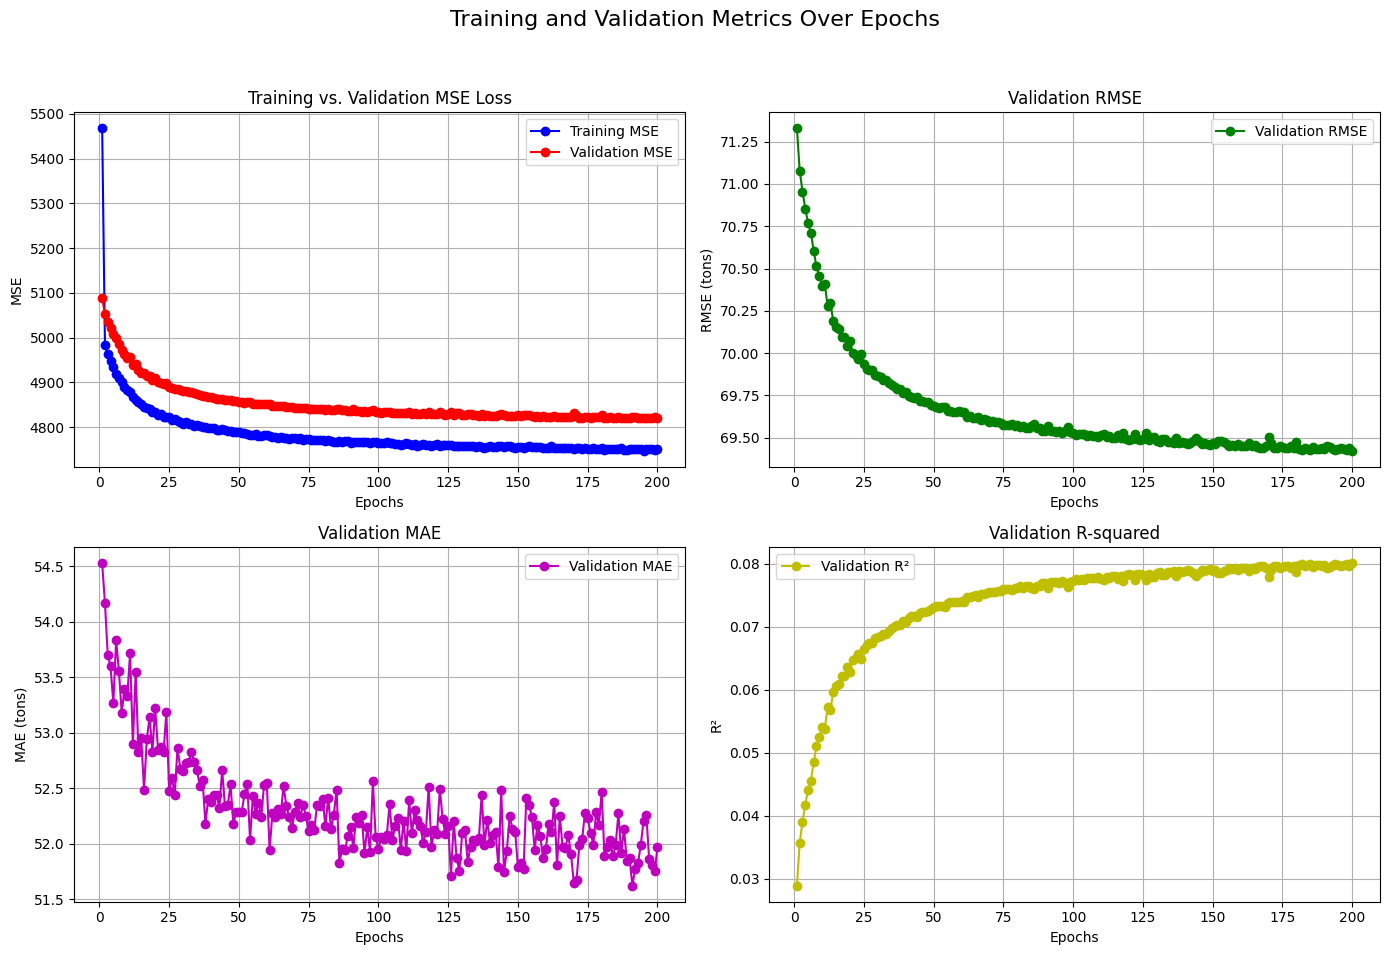


🔄 Loading best model from epoch 200 for final inference...

🏆 Running final evaluation on the inference set...


Inference:   0%|          | 0/174 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Final Inference Metrics (using best model):
  - MSE:  4983.7930
  - RMSE: 70.5960 (tons)
  - MAE:  52.8221 (tons)
  - R²:   0.0726
📈 Metrics and results saved to: /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/train_results_LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.json
💾 Best model is saved at: /content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/Results/LP_1_Layer_v1_BS16_LR005_EP200_SEED42_ValSpl20.pth


In [ ]:
# ==============================================================================
# 7. MAIN EXECUTION
# ==============================================================================
if __name__ == '__main__':
    print(f"Using device: {DEVICE.upper()}")
    print(f"Starting Run Version: {VERSION}")
    #mount_gdrive()
    prepare_data()

    print("Creating and splitting datasets...")
    full_train_dataset = BiomassDataset(features_dir=FULL_TRAIN_FEATURES_DIR, labels_dir=FULL_TRAIN_LABELS_DIR)

    # Check if we have any data to train on
    if len(full_train_dataset) == 0:
        print("FATAL: No matching data found. Exiting.")
    else:
        val_size = int(VALIDATION_SPLIT * len(full_train_dataset))
        train_size = len(full_train_dataset) - val_size
        train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

        inference_dataset = BiomassDataset(features_dir=INFERENCE_FEATURES_DIR, labels_dir=INFERENCE_LABELS_DIR)

        print("✅ Datasets created and split successfully.")
        print(f"  - Training samples:   {len(train_dataset)}")
        print(f"  - Validation samples: {len(val_dataset)}")
        print(f"  - Inference samples:  {len(inference_dataset)}")

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
        inference_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

        print("\nInitializing model...")
        model = LinearProbingModel().to(DEVICE)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        print("✅ Model initialized.")

        train_loss_history = []
        val_metrics_history = []
        best_val_mse = float('inf')
        best_epoch = 0
        best_model_path = os.path.join(MODEL_SAVE_BASE_PATH, f"{VERSION}.pth")

        print(f"\n🔥 Starting training for {NUM_EPOCHS} epochs...")
        for epoch in range(NUM_EPOCHS):
            print(f"\n--- Epoch {epoch + 1}/{NUM_EPOCHS} ---")
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_metrics = evaluate_model(model, val_loader, DEVICE, desc="Validation")

            train_loss_history.append(train_loss)
            val_metrics_history.append(val_metrics)

            print(f"Epoch {epoch + 1} Summary:")
            print(f"  -> Avg. Training MSE Loss: {train_loss:.4f}")
            print(f"  -> Validation Metrics:")
            print(f"     - MSE:  {val_metrics['mse']:.4f}")
            print(f"     - RMSE: {val_metrics['rmse']:.4f} (tons)")
            print(f"     - MAE:  {val_metrics['mae']:.4f} (tons)")
            print(f"     - R²:   {val_metrics['r2']:.4f}")

            # Check if this is the best model so far and save it ---
            if val_metrics['mse'] < best_val_mse:
                best_val_mse = val_metrics['mse']
                best_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_path)
                print(f"  -> ✅ New best model found! Saved to {best_model_path}")

        print("\n🎉 Training finished!")
        print(f"🏆 Best model was from Epoch {best_epoch} with a validation MSE of {best_val_mse:.4f}")

        # Plot and save the curves
        plot_save_path = os.path.join(MODEL_SAVE_BASE_PATH, f"train_val_curves_{VERSION}.png")
        print("\n📊 Plotting and saving training curves...")
        plot_curves(train_loss_history, val_metrics_history, save_path=plot_save_path)

        # Load the best model's weights before final evaluation ---
        print(f"\n🔄 Loading best model from epoch {best_epoch} for final inference...")
        model.load_state_dict(torch.load(best_model_path))

        print("\n🏆 Running final evaluation on the inference set...")
        inference_metrics = evaluate_model(model, inference_loader, DEVICE, desc="Inference")
        print("\nFinal Inference Metrics (using best model):")
        print(f"  - MSE:  {inference_metrics['mse']:.4f}")
        print(f"  - RMSE: {inference_metrics['rmse']:.4f} (tons)")
        print(f"  - MAE:  {inference_metrics['mae']:.4f} (tons)")
        print(f"  - R²:   {inference_metrics['r2']:.4f}")

        # --- Save results to a JSON file ---
        results = {
            "version": VERSION,
            "best_epoch": best_epoch,
            "best_validation_mse": best_val_mse,
            "train_loss_history": train_loss_history,
            "val_metrics_history": val_metrics_history,
            "inference_metrics_on_best_model": inference_metrics,
            "hyperparameters": {
                "learning_rate": LEARNING_RATE,
                "batch_size": BATCH_SIZE,
                "num_epochs": NUM_EPOCHS,
                "validation_split": VALIDATION_SPLIT,
                "random_seed": RANDOM_SEED
            }
        }
        results_save_path = os.path.join(MODEL_SAVE_BASE_PATH, f"train_results_{VERSION}.json")
        with open(results_save_path, 'w') as f:
            json.dump(results, f, indent=4)
        print(f"📈 Metrics and results saved to: {results_save_path}")

        # Note: The 'best_model' is already saved during the loop. No need to save again here.
        print(f"💾 Best model is saved at: {best_model_path}")

In [ ]:
!git clone https://github.com/CaptainMorgigi/MA_LP_Regression_Model.git


Cloning into 'MA_LP_Regression_Model'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
# Example: !mv "/content/My Awesome Code.ipynb" "/content/my-data-science-project/"
!mv "/content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/LP_1_Layer_v1.ipynb" "/content/MA_LP_Regression_Model/"

mv: cannot stat '/content/drive/MyDrive/Colab_Notebooks/Training/Linear_Probing/LP_1_Layer_v1.ipynb': No such file or directory


In [ ]:
!ls /content/

MA_LP_Regression_Model	sample_data
